In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline


In [20]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [21]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [22]:
team_1 = 'Delhi Capitals'
team_2 = 'Royal Challengers Bangalore'

In [23]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

In [24]:
def clean(row):
    if row['extra_runs']>= row['batsman_runs']:
        row['extra_runs'] -= row['batsman_runs']
        
    return row

delivery = delivery.apply(clean, axis=1)
delivery['total_runs'] = delivery['extra_runs'] + delivery['batsman_runs']

# Winning Probability of Teams

Text(0.5, 1.0, 'RCB Total Runs Score Stats Per Count')

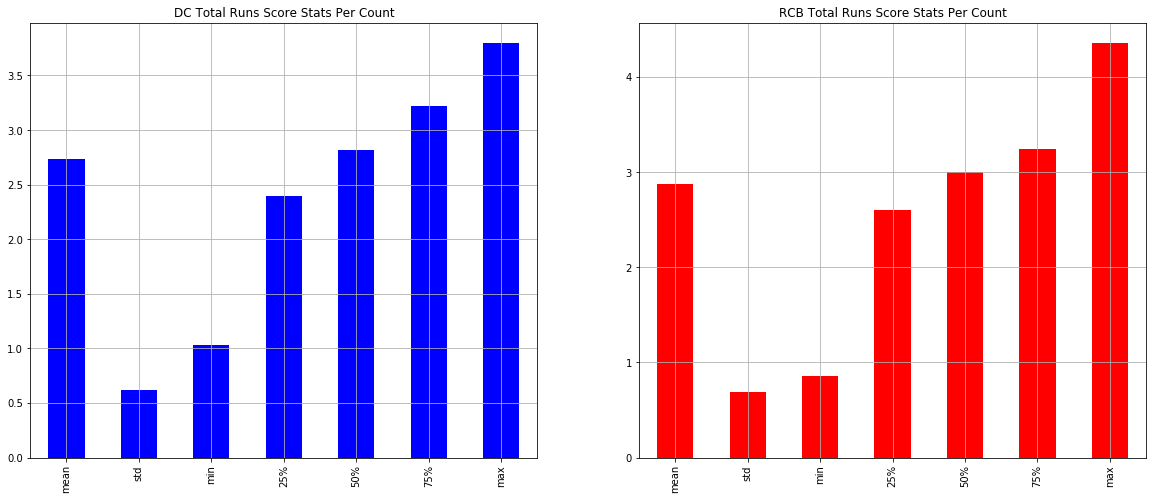

In [25]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
dc_runs = delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs']
rcb_runs = delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs']
(dc_runs.describe()[1:]/dc_runs.describe()[0]).plot(ax=ax[0], kind='bar', grid=True, color='blue')
(rcb_runs.describe()[1:]/rcb_runs.describe()[0]).plot(ax=ax[1], kind='bar', grid=True, color='red')
ax[0].set_title("DC Total Runs Score Stats Per Count")
ax[1].set_title("RCB Total Runs Score Stats Per Count")

Text(0.5, 1.0, 'Percentage of Winning')

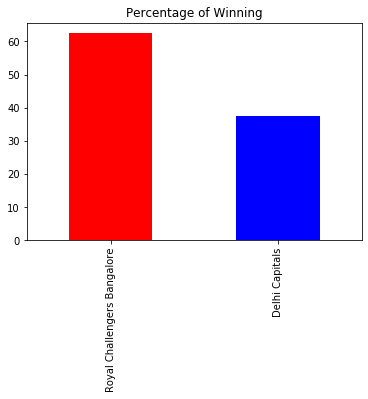

In [28]:
wins = pd.DataFrame(matches1[(matches1['team1'].isin([team_1, team_2])) & (matches1['team2'].isin([team_1, team_2]))]['winner'].value_counts())
wins['Percentage Win Chance'] = (wins['winner']/sum(wins['winner']))*100
wins['Percentage Win Chance'].plot(kind='bar', color=['red', 'blue'])
plt.title('Percentage of Winning')

# Strike Rate

In [34]:
def strike_rate(batsman):
    ratios = list()
    for match_id in delivery[(delivery['batsman']==batsman)]['match_id'].unique():
        match = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id)]
        total_runs = sum(match['batsman_runs'])
        total_balls = len(match)
        total_4 = len(match[match['batsman_runs']==4])
        total_6 = len(match[match['batsman_runs']==4])
        
        if total_balls>10: 
            rate = total_runs*100/total_balls
            ratios.append([batsman, total_runs, total_balls, total_4, total_6, rate])
        
    return ratios

In [58]:
rcb_team = ['S Dube' ,'Washington Sundar','AB de Villiers' ,'V Kohli', 'M Ali', 'YS Chahal', 'CH Morris', 'S Dube', 'Mohammed Siraj', 'N Saini']
dc_team = ['P Shaw', 'S Dhawan', 'SS Iyer', 'RR Pant', 'S Hetmyer', 'MP Stoinis', 'AR Patel', 'R Ashwin', 'HV Patel', 'K Rabada']

In [59]:
team = rcb_team + dc_team

In [64]:
batsman_sr = list()
for man in team:
    batsman_sr += (strike_rate(man))

In [66]:
batsman_sr_df = pd.DataFrame(data=batsman_sr, columns=['Batsman', 'Runs', 'Balls', '4s', '6s', 'SR'])
batsman_sr_df.head()

,Batsman,Runs,Balls,4s,6s,SR
0,S Dube,24,16,0,0,150.000000
1,Washington Sundar,37,21,1,1,176.190476
2,AB de Villiers,89,49,3,3,181.632653
3,AB de Villiers,19,22,0,0,86.363636
4,AB de Villiers,29,32,1,1,90.625000


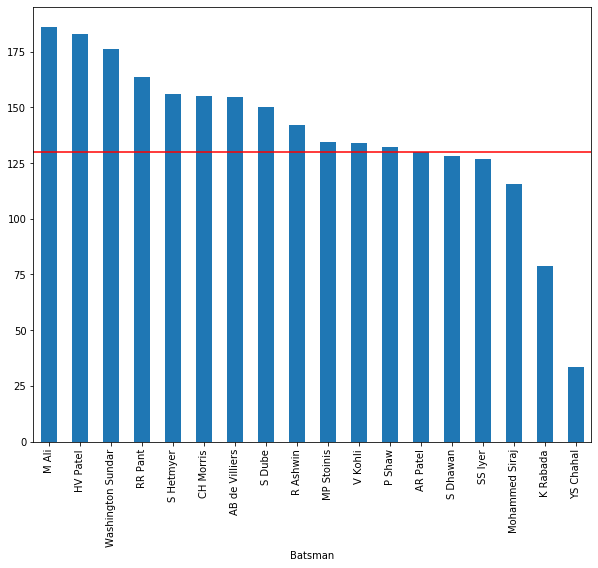

In [71]:
batsman_sr_df.groupby("Batsman").mean().sort_values(by='SR', ascending=False)['SR'].plot(kind='bar', figsize=(10,8))
plt.axhline(y=130, color='red')

In [73]:
batsman_sr_df.groupby("Batsman").mean().sort_values(by='SR', ascending=False).head(12)

,Runs,Balls,4s,6s,SR
Batsman,,,,,
M Ali,49.200000,26.200000,2.800000,2.800000,185.861335
HV Patel,30.000000,16.500000,0.500000,0.500000,183.088235
Washington Sundar,37.000000,21.000000,1.000000,1.000000,176.190476
RR Pant,47.750000,28.222222,4.083333,4.083333,163.386090
S Hetmyer,78.000000,50.000000,4.000000,4.000000,156.000000
CH Morris,35.250000,22.000000,2.500000,2.500000,155.161697
AB de Villiers,54.875000,33.281250,4.031250,4.031250,154.774625
S Dube,24.000000,16.000000,0.000000,0.000000,150.000000
R Ashwin,27.800000,19.000000,2.400000,2.400000,142.106926


Not considering the batsmen in this graph which has lower chances of batting as compared to other opening and front line batsmen. Taking batsmen with higher chances of hitting 4 and 6, the range would be 5 - 7

# Rabada balls to first wicket

In [74]:
def balls_to_wicket(bowler):
    balls = list()
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        match = delivery[(delivery['bowler']==bowler) & (delivery['match_id']==match_id)]
        ball = 0
        for w in match['player_dismissed']:
            ball += 1
            if w == 1:
                break
        if (ball <= 24):
            balls.append(ball)
    return balls

Text(0.5, 1.0, 'Rabada Balls to FIrst Wicket Histogram')

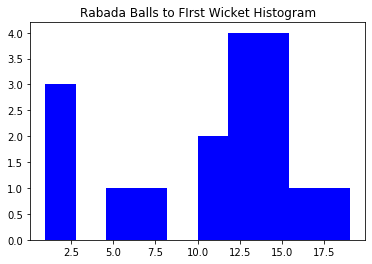

In [82]:
plt.hist(balls_to_wicket('K Rabada'), color='blue')
plt.title("Rabada Balls to FIrst Wicket Histogram")

In [84]:
rabada_matches = len(delivery[(delivery['bowler']=='K Rabada')]['match_id'].unique())
rabada_wickets = len(delivery[(delivery['bowler']=='K Rabada') & (delivery['player_dismissed']==1)]['match_id'].unique())
print("Percentage Chances of taking atleast one wicket in this match is:", rabada_wickets*100/rabada_matches, '%')

Percentage Chances of taking atleast one wicket in this match is: 88.88888888888889 %


Text(0.5, 1.0, 'Rabada Wickets Histogram vs Overs')

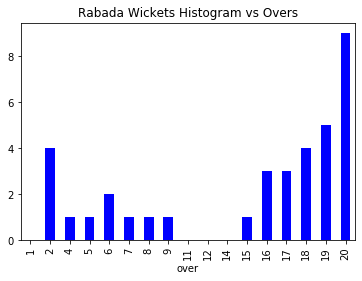

In [85]:
delivery[(delivery['bowler']=='K Rabada')].groupby('over').sum()['player_dismissed'].plot( kind='bar', color='blue')
plt.title("Rabada Wickets Histogram vs Overs")

The chances of K Rabda taking wicket in deah overs in high. This suggests that there is high chances of taking wicket in his 3rd or 4th over, so according to histogram this might be the 3rd over.

# Bowlers with Economy Rate < 8

In [91]:
def economy_rate(bowler):
    rates = list()
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        match = delivery[(delivery['bowler']==bowler) & (delivery['match_id']==match_id)]
        boundaries = len(match[(match['total_runs'].isin([4, 5, 6, 7]))])
        t_runs = sum(match['total_runs'])
        balls = len(match)
        dot_balls = len(match[match['total_runs']==0])
        rate = t_runs*6/balls
        if balls/6 > 2:
            rates.append([bowler, t_runs, balls, boundaries, dot_balls, round(rate, 2)])
        
    return rates

In [93]:
bowlers_performance = list()
for player in team:
    bowlers_performance += (economy_rate(player))

bowlers_performance_df = pd.DataFrame(data=bowlers_performance, columns=['Bowler', 'Runs', 'Balls', 'Boundary', 'Dots', 'ER'])
bowlers_performance_df.head()

,Bowler,Runs,Balls,Boundary,Dots,ER
0,Washington Sundar,21,20,2,5,6.30
1,Washington Sundar,26,24,3,8,6.50
2,Washington Sundar,33,18,5,6,11.00
3,Washington Sundar,19,18,3,9,6.33
4,Washington Sundar,23,18,3,7,7.67


In [98]:
bowlers_performance_df.groupby('Bowler').mean().sort_values(by='ER')

,Runs,Balls,Boundary,Dots,ER
Bowler,,,,,
M Ali,20.888889,21.222222,2.000000,8.555556,6.075556
R Ashwin,28.538462,23.512821,2.692308,6.794872,7.393590
YS Chahal,29.714286,23.571429,3.387755,8.448980,7.661633
Washington Sundar,26.428571,21.285714,3.071429,7.285714,7.720714
AR Patel,28.130435,22.000000,2.934783,6.760870,7.804783
K Rabada,32.222222,24.111111,4.333333,8.666667,8.023333
CH Morris,30.606061,22.545455,4.151515,7.939394,8.225152
N Saini,33.416667,24.500000,5.500000,11.166667,8.264167
Mohammed Siraj,35.652174,23.869565,4.913043,7.956522,9.003913


According to the above table, the mean values suggests that 2 bowlers might be among those who have less than 8 economy, more than 8 dots and less than 4 bounadries. 

# Summary

1. Using the winners column the chances of winning were compared. The total score per match for both the teams were also compared to evaluate their batting performance.
2. A function was created to calculate the strike rate of batsmen. In that, data wrt to batsman was filtered per match and boundaries, total balls, total runs, were calculated using batsman_runs column and mean strike rate was calculated. Also, the no.of 4s and 6s were also calculated by the function which helped in comparing batsmen.
3. A function to calculate ball to the first wicket was calculated by using player_dismissed column and calculating balls until wicket. Then using histogram and wickets vs overs graph of Rabada, the estimation was done. 
4. A function to calculate the economy rate per match of bowlers were created using total_runs column. The function also calculated boundaries, dot balls per match. Using this, the mean rate, boundaries and dots were calculated and compared. 